In [1]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import os
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from matplotlib.colors import TABLEAU_COLORS

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation import test

from uncertain.explicit import Bias, MF, CPMF, OrdRec, BeMF
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

data = pd.read_csv('data.csv')
data.columns = ['user', 'item', 'score', 'timestamps']
data = Data(data, implicit=False)

os.chdir('Movielens')

MovieLens data prepared: 6040 users, 3416 items.
724551 train, 77534 validation and 197526 test interactions.


  0%|          | 0/6040 [00:00<?, ?it/s]

{'ratings': {'RMSE': 0.8961475827401935,
  'avg_unc': 1.00531,
  'std_unc': 0.28582996,
  'RPI': 0.350578626819051,
  'Classification': 0.5594883402035874,
  'Quantile RMSE': array([0.87015744, 0.82810157, 0.80948756, 0.82000841, 0.79657753,
         0.81878763, 0.83428975, 0.8542301 , 0.83686553, 0.86379003,
         0.88662017, 0.88672562, 0.88966381, 0.90220953, 0.91997225,
         0.93375913, 0.94261374, 0.98551712, 1.01651769, 1.15046101])},
 'accuracy': {'Precision': array([0.07201987, 0.06754967, 0.06445916, 0.06105132, 0.05970199,
         0.05885762, 0.05754494, 0.05593957, 0.05507726, 0.05374172]),
  'Recall': array([0.00494128, 0.00934455, 0.01311488, 0.01628262, 0.01956197,
         0.02295312, 0.02629745, 0.02919904, 0.03244778, 0.03468745]),
  'NDCG': array([0.07201987, 0.1496751 , 0.2149294 , 0.26976773, 0.31626052,
         0.36144665, 0.39587576, 0.43103193, 0.46534814, 0.4916442 ]),
  'Diversity': array([0.35934964, 0.36383474, 0.36879938, 0.37212393, 0.37475691,
   

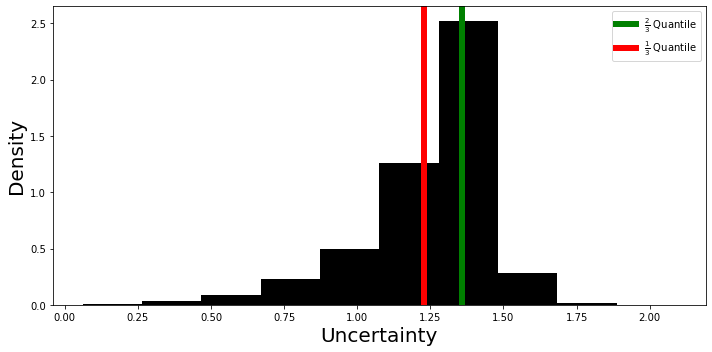

In [2]:
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test(model, data, name='CPMF', max_k=10)

In [7]:
from uncertain.core import UncertainRecommender, VanillaRecommender
isinstance(model, VanillaRecommender)

False

In [6]:
model.uncertain_predict_user(torch.tensor(0), 4)

array([0.97266485, 0.31432978, 0.64085749, ..., 0.03179307, 0.20579085,
       0.18361146])

# ExplicitMF (FunkSVD)

In [ ]:
for wd in [10]:
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=wd)
    train(model, data, path='checkpoints/baseline', name=f'wd={wd}')

In [ ]:
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test_recommendations(model, data, name='Baseline', max_k=10)

# Ensemble

In [ ]:
for i in range(2):
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=0.0001)
    train(model, data, path='checkpoints/ensemble', name=f'{i}')

# Resample

In [ ]:
og = deepcopy(data.train)
for i in range(3):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=0.0001)
    train(model, data, path='checkpoints/resample', name=f'{i}')
data.train = og

# Zhu et. al

In [ ]:
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
errors = np.empty(len(data.train))
og = deepcopy(data.train)
og_val = deepcopy(data.val)
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=2, shuffle=True).split(data.train)):
    test = og[test_idx]
    data.train = og[train_idx]
    model_ = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0001, weight_decay=model.weight_decay)
    train(model_, data, path='checkpoints/cv', name=f'cv{i}')
    errors[test_idx] = np.abs(model_.predict(torch.tensor(test[:, 0]).long(), torch.tensor(test[:, 1]).long()) - test[:, 2])
data.train = deepcopy(og)
data.train[:, 2] = errors
data.val[:, 2] = np.abs(model.predict(torch.tensor(data.val[:, 0]).long(), torch.tensor(data.val[:, 1]).long()) - data.val[:, 2])

# DoubleMF
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=0)
train(model, data, path='checkpoints/cv', name=f'MF')

# Bias
model = Bias(data.n_user, data.n_item, lr=0.0001)
train(model, data, path='checkpoints/cv', name=f'Bias')

#Fix
data.train = og
data.val = og_val

# CPMF

In [ ]:
for wd in [0.001]:
    for lr in [0.00001]:
        model = CPMF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=wd, lr_var=lr)
        train(model, data, path='checkpoints/cpmf', name=f'wd={wd}-lr={lr}')

# OrdRec

In [ ]:
data.to_ordinal()
for wd in [0.001]:
    for lr in [0.0005]:
        model = OrdRec(data.n_user, data.n_item, data.score_labels, embedding_dim=10, lr=0.0002, weight_decay=wd, lr_step=lr)
        train(model, data, path='checkpoints/ordrec', name=f'wd={wd}-lr={lr}')

# BeMF

In [ ]:
data.to_ordinal()
for wd in [0.01, 0.001, 0]:
    for lr in [0.05, 0.01, 0.005]:
        model = BeMF(data.n_user, data.n_item, data.score_labels, embedding_dim=50, lr=lr, weight_decay=wd)
        train(model, data, path='checkpoints/bemf', name=f'wd={wd}-lr={lr}')

# Results

In [ ]:
# Baseline
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test_recommendations(model, data, name='Baseline', max_k=4)

# Heuristics
user_support = np.bincount(data.train_val.user)
item = data.train_val.groupby('item').agg({'user': 'size', 'score': 'var'})
empty = np.where(~pd.Series(np.arange(data.n_item)).isin(item.index))[0]
empty = pd.DataFrame(np.full((len(empty), 2), float('NaN')), index=empty, columns=['user', 'score'])
item = item.append(empty).sort_index().fillna(0).to_numpy()
test_recommendations(UserHeuristic(base_MF=model, uncertainty=-user_support), data, name='User_support', max_k=4)
test_recommendations(ItemHeuristic(base_MF=model, uncertainty=-item[:, 0]), data, name='Item_support', max_k=4)
test_recommendations(ItemHeuristic(base_MF=model, uncertainty=item[:, 1]), data, name='Item_variance', max_k=4)

# Ensemble
models = [model]
for file in os.listdir('checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
test_recommendations(ensemble, data, name='Ensemble', max_k=4)

# Resample
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(model, models)
test_recommendations(resample, data, name='Resample', max_k=4)

# Zhu
for file in os.listdir('checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('checkpoints/cv', file))
bias_cv = UncertainWrapper(model, bias)
test_recommendations(bias_cv, data, name='CV-Bias', max_k=4)
mf_cv = UncertainWrapper(model, mf)
test_recommendations(mf_cv, data, name='CV-PMF', max_k=4)

# CPMF
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test_recommendations(model, data, name='CPMF', max_k=4)

# OrdRec
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/ordrec', min(files, key=files.get)))
test_recommendations(model, data, name='OrdRec', max_k=4)

# BeMF
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/bemf', min(files, key=files.get)))
test_recommendations(model, data, name='BeMF', max_k=4)

In [ ]:
# Load
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
results_df = pd.DataFrame.from_dict(results, orient='index')
keys = results_df.index.to_list()
colors = [c for c in list(TABLEAU_COLORS)] + ['k']
colors = {keys[i]:colors[i] for i in range(len(keys))}

# Rating prediction evaluation
ratings = results_df[['RMSE', 'RPI', 'Classification']]
print(ratings)

# Uncertainty-RMSE curve
keys = [key for key in results_df.index.to_list() if key != 'Baseline']
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(np.arange(1, 21), results_df['Quantile RMSE'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels([round(elem, 2) for elem in np.linspace(start=0.05, stop=1, num=20).tolist()])
ax.set_xlabel('Uncertainty quantile', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RMSE-uncertainty.pdf')

# RRI
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(np.arange(1, 5), results_df['RRI'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xlabel('K', fontsize=20)
ax.set_ylabel('RRI@K', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RRI.pdf')

# Top-K accuracy metrics
keys = ['Baseline', 'CPMF', 'Ensemble', 'OrdRec', 'BeMF']
f, ax = plt.subplots(ncols=3, figsize=(18, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 5), results_df['Precision'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 5), results_df['Recall'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[2].plot(np.arange(1, 5), results_df['NDCG'][key],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 5))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('Precision@K', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Recall@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
ax[2].set_xlabel('K', fontsize=20)
ax[2].set_ylabel('NDCG@K', fontsize=20)
ax[2].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

In [ ]:
# Rating prediction evaluation
cols = [col for col in results_df.columns if 'Cuts' in col]
results_df = results_df.drop('Baseline')
for col in cols:
    print('\n', col)
    print(pd.DataFrame(np.vstack(results_df[col].to_numpy()), index=results_df.index, columns=['Base', 'Cut 1/3', 'Cut 2/3']))

In [ ]:
\mu + 2*\sigma

avg - err

p(r > 3.5) 4 / 5